# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [1]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transformations.
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to PyTorch tensor.
    transforms.Normalize((0.5,), (0.5,)) # Normalizing the data here to shifts pixel values to [-1, 1] to help the neural network learn.
])

# Create the full training set.
full_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Define the sizes for the training (80%) and validation (20%) sets.
train_split_percentage = 0.8
train_size = int(len(full_train_dataset) * train_split_percentage)
validation_size = len(full_train_dataset) - train_size

# Split the data into training and validation sets and define the dataloaders.
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, validation_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Create test set and define test dataloader.
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

transforms.ToTensor(): The image data has to be converted into tensors so it can be input into the nueral network.

transforms.Normalize((0.5, ), (0.5, )): Normalizes values from range [0, 1] to [-1, 1] which should help the neural network train.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.transpose(1,2,0).T.squeeze().T)
        plt.show()

6


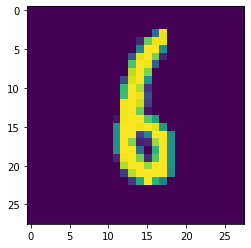

8


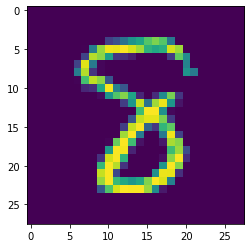

4


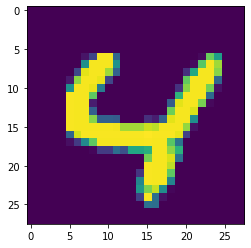

4


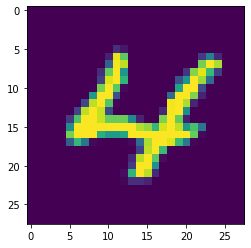

9


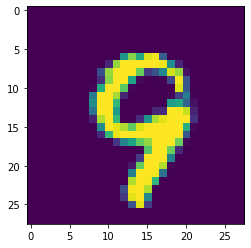

Max pixel value: 1.0
Min pixel value: -1.0
Training dataset size: 48000
Shape of train_images: torch.Size([32, 1, 28, 28])
Shape of train_labels: torch.Size([32])


In [6]:
# Show the first 5 images and their associated labels.
show5(train_loader)

# Get one batch of data.
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Check the range of pixel values (should be in range [-1, 1]).
print("Max pixel value:", images.max().item())
print("Min pixel value:", images.min().item())

# View the dimensions of the training set.
print("Training dataset size:", len(train_dataset))
train_images, train_labels = next(iter(train_loader))
print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)

1


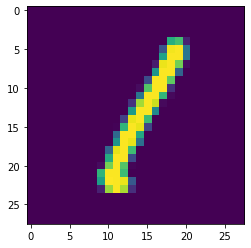

7


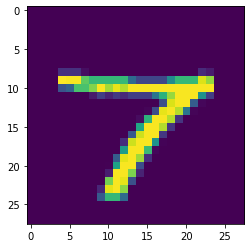

5


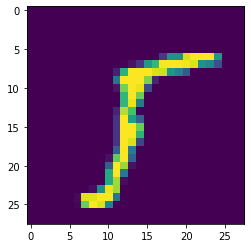

3


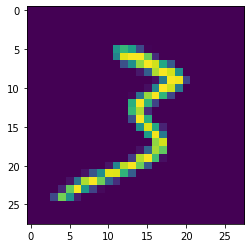

3


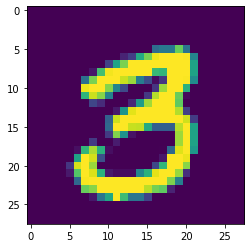

In [7]:
show5(validation_loader)

7


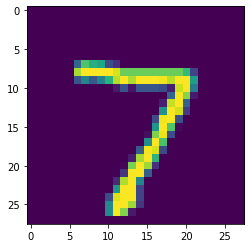

2


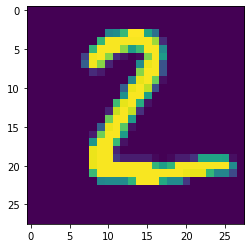

1


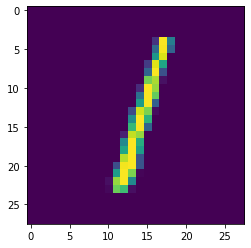

0


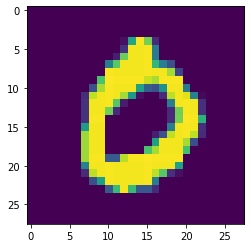

4


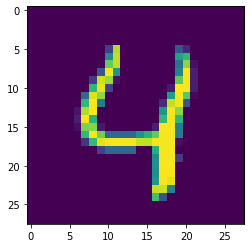

Test dataset size: 10000
Shape of test_images: torch.Size([32, 1, 28, 28])
Shape of test_labels: torch.Size([32])


In [8]:
show5(test_loader)

# View the dimensions of the test dataset.
print("Test dataset size:", len(test_dataset))
test_images, test_labels = next(iter(test_loader))
print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
# Define the class for your neural network.
# Network consists of two convolutional layers (ReLU activation) and 2 fully connected layers.
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5, padding=2)
        self.fully_connnected_layer1 = nn.Linear(16 * 7 * 7, 256)
        self.dropout = nn.Dropout(0.2)
        self.fully_connected_layer2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv_layer1(x)))
        x = self.pool(F.relu(self.conv_layer2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fully_connnected_layer1(x))
        x = self.dropout(x)
        x = self.fully_connected_layer2(x)
        return x

# Instantiate the model.
net = Net()
net.to(device)

Net(
  (conv_layer1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fully_connnected_layer1): Linear(in_features=784, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fully_connected_layer2): Linear(in_features=256, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
# Use Stochastic Gradient Descent (SGD) optimizer.
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-5)

# Use Cross Entropy Loss since it's widely used for multi-class classification problems.
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
## Trains the neural network and returns the training accuracy and loss percentages.
def train(net, train_loader, optimizer, criterion, device):
    net.train()
    train_loss = 0.0
    train_correct = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero out the gradients of the optimizer.
        optimizer.zero_grad()

        # Get the outputs and compute loss.
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Compute the loss gradient using the backward method.
        loss.backward()
        
        # Update the parameters by taking a step with the optimizer.
        optimizer.step()

        # Compute the accuracy and loss.
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    
    # Compute the accuracy and loss.
    train_accuracy_percent = (train_correct/len(train_loader.dataset))*100
    train_loss_percent = (train_loss/len(train_loader.dataset))*100

    return train_accuracy_percent, train_loss_percent

In [12]:
## Validates the neural network and returns the validation accuracy and loss percentages.
def validate(net, validation_loader, criterion, device):
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get the outputs and compute loss.
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Compute the accuracy and loss.
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    
    # Compute the accuracy and loss.
    validation_accuracy_percent = (val_correct/len(validation_loader.dataset))*100
    validation_loss_percent = (val_loss/len(validation_loader.dataset))*100
        
    return validation_accuracy_percent, validation_loss_percent

In [13]:
num_epochs = 10

# Establish a list for our history.
train_loss_history = list()
val_loss_history = list()

# For each epoch train and validate the neural network.
for epoch in range(num_epochs):
    train_accuracy_percent, train_loss_percent = train(net, train_loader, optimizer, criterion, device)
    print(f'Epoch {epoch + 1} training accuracy: {train_accuracy_percent:.2f}% training loss: {train_loss_percent:.5f}')
    train_loss_history.append(train_loss_percent)
    
    validation_accuracy_percent, validation_loss_percent = validate(net, validation_loader, criterion, device)
    print(f'Epoch {epoch + 1} validation accuracy: {validation_accuracy_percent:.2f}% validation loss: {validation_loss_percent:.5f}')
    val_loss_history.append(validation_loss_percent)

Epoch 1 training accuracy: 24.92% training loss: 7.13600
Epoch 1 validation accuracy: 51.68% validation loss: 7.05270
Epoch 2 training accuracy: 54.69% training loss: 6.78051
Epoch 2 validation accuracy: 63.96% validation loss: 6.13811
Epoch 3 training accuracy: 73.64% training loss: 3.83695
Epoch 3 validation accuracy: 85.97% validation loss: 1.84371
Epoch 4 training accuracy: 86.45% training loss: 1.52208
Epoch 4 validation accuracy: 90.39% validation loss: 1.10660
Epoch 5 training accuracy: 89.83% training loss: 1.09714
Epoch 5 validation accuracy: 92.28% validation loss: 0.88172
Epoch 6 training accuracy: 91.38% training loss: 0.91603
Epoch 6 validation accuracy: 93.27% validation loss: 0.75466
Epoch 7 training accuracy: 92.25% training loss: 0.79898
Epoch 7 validation accuracy: 93.56% validation loss: 0.67683
Epoch 8 training accuracy: 93.12% training loss: 0.71671
Epoch 8 validation accuracy: 94.44% validation loss: 0.60819
Epoch 9 training accuracy: 93.56% training loss: 0.65952

Plot the training loss (and validation loss/accuracy, if recorded).

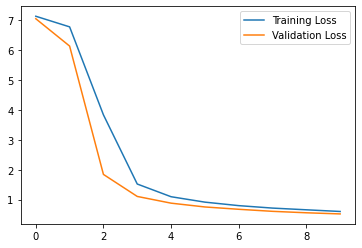

In [14]:
# Plot the training and validation loss history.
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
def test(net, test_loader, criterion, device):
    test_loss = 0.0
    test_correct = 0
    net.eval()
    
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
        
    test_accuracy_percent = (test_correct/len(test_loader.dataset))*100
    test_loss_percent = (test_loss/len(test_loader.dataset))*100
        
    return test_accuracy_percent, test_loss_percent

In [16]:
test_accuracy_percent, test_loss_percent = test(net, test_loader, criterion, device)

# Print testing accuracy to the notebook.
print(f'Testing accuracy: {test_accuracy_percent:.2f}% testing loss: {test_loss_percent:.2f}')

Testing accuracy: 95.39% testing loss: 0.47


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [17]:
# Initialize a new neural network.
net = Net()
net.to(device)

# Optimizer updates: learning rate 0.0001 to 0.0003 and momentum from 0.9 to 0.92.
optimizer = optim.SGD(net.parameters(), lr=0.0003, momentum=0.92, weight_decay=1e-5)

In [18]:
num_epochs = 25

# Establish a list for our history.
train_loss_history = list()
val_loss_history = list()

# Set best validation loss to infinity, since we're going to monitor validation loss for improvement
best_val_loss = float("inf")

# Threshold for minimum performance improvement
thresh = 0.01

# How many times performance has fallen below the threshold
below_threshold = 0

# How many epochs we should allow performance improvement to fall below threshold
patience = 2
    
for epoch in range(num_epochs):
    train_accuracy_percent, train_loss_percent = train(net, train_loader, optimizer, criterion, device)
    validation_accuracy_percent, validation_loss_percent = validate(net, validation_loader, criterion, device)
    
    print(f'Epoch {epoch + 1} training accuracy: {train_accuracy_percent:.2f}% training loss: {train_loss_percent:.5f}')
    train_loss_history.append(train_loss_percent)
    print(f'Epoch {epoch + 1} validation accuracy: {validation_accuracy_percent:.2f}% validation loss: {validation_loss_percent:.5f}')
    val_loss_history.append(validation_loss_percent)
    
    # Calculate the difference between the best validation loss and the best validation loss.
    diff = best_val_loss - validation_loss_percent

    # Set the best validation loss to the current validation loss if it's smaller.
    if best_val_loss > validation_loss_percent:
        best_val_loss = validation_loss_percent

    # Check if the difference between the best val loss and the current val loss is under threshold.
    if diff <= thresh:
        # Increase count below threshold.
        below_threshold += 1
        # Check if the number below threshold is greater than our patience and stop training if it is.
        if below_threshold >= patience:
            break

Epoch 1 training accuracy: 58.80% training loss: 4.32084
Epoch 1 validation accuracy: 88.17% validation loss: 1.25386
Epoch 2 training accuracy: 89.48% training loss: 1.07033
Epoch 2 validation accuracy: 92.88% validation loss: 0.72331
Epoch 3 training accuracy: 92.99% training loss: 0.71536
Epoch 3 validation accuracy: 95.09% validation loss: 0.52990
Epoch 4 training accuracy: 94.56% training loss: 0.55553
Epoch 4 validation accuracy: 95.75% validation loss: 0.43082
Epoch 5 training accuracy: 95.60% training loss: 0.45509
Epoch 5 validation accuracy: 96.28% validation loss: 0.37531
Epoch 6 training accuracy: 96.24% training loss: 0.38868
Epoch 6 validation accuracy: 96.86% validation loss: 0.31360
Epoch 7 training accuracy: 96.62% training loss: 0.34594
Epoch 7 validation accuracy: 97.21% validation loss: 0.28508
Epoch 8 training accuracy: 96.90% training loss: 0.30657
Epoch 8 validation accuracy: 97.50% validation loss: 0.25514
Epoch 9 training accuracy: 97.17% training loss: 0.28742

In [19]:
test_accuracy_percent, test_loss_percent = test(net, test_loader, criterion, device)

# Print testing accuracy to the notebook.
print(f'Testing accuracy: {test_accuracy_percent:.2f}% testing loss: {test_loss_percent:.2f}')

Testing accuracy: 98.13% testing loss: 0.18


## Saving your model
Using `torch.save`, save your model for future loading.

In [20]:
torch.save(net, 'model.pth')